## Classical (Markowitz) portfolio optimization

\begin{align}
\max_{w} \quad & \mu^T w - \gamma w^T \Sigma w \\
\text{s.t.} \quad & \mathbf{1}^T w = 1, \\
& w \in \mathcal{W}
\end{align}
$$

In [1]:
from pyoptsparse import SLSQP, Optimization
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

np.random.seed(0)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma) # Positive Definite Matrix - Covariance
SAMPLES = 100
gammaList = np.logspace(-2, 3, num=SAMPLES)

def solve(gamma):
    def objfunction(xdict):
        w = xdict["xvars"]
        funcs = {}
        funcs["obj"] = - (mu.T.dot(w) - gamma * w.T.dot(Sigma).dot(w))
        conval = [0] * 1
        conval[0] = np.sum(w) - 1
        funcs["con"] = conval
        fail = False
        
        return funcs, fail
    optProb = Optimization("Test", objfunction)
    optProb.addVarGroup("xvars", n, "c", lower=0.0, upper=1.0, value = 0.1)
    optProb.addConGroup("con", 1, lower=0.0, upper=0.0)
    optProb.addObj("obj")
    
    # print(optProb)

    optOptions = {"IPRINT": -1}
    opt = SLSQP(options=optOptions)
    sol = opt(optProb, sens="FD")
    return sol

# Sigma



Optimization Problem -- Test
    Objective Function: objfunction

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    0.0163
       User Objective Time :       0.0007
       User Sensitivity Time :     0.0057
       Interface Time :            0.0070
       Opt Solver Time:            0.0030
    Calls to Objective Function :      33
    Calls to Sens Function :           14


   Objectives
      Index  Name            Value
          0  obj     4.596189E+02

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name      Type      Lower Bound            Value      Upper Bound     Status
          0  xvars_0      c     0.000000E+00     2.959147E-01     1.000000E+00           
          1  xvars_1      c     0.000000E+00     2.169806E-07     1.000000E+00          l
          2  xvars_2      c     0.000000E+00     2.298172E-07     1.000000E+00          l
          3  xvars_3      c     0.00000

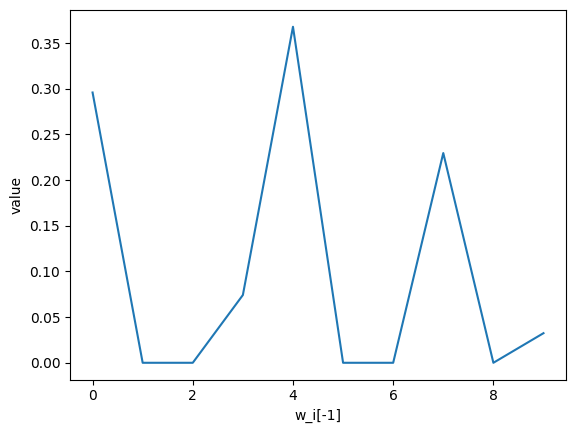

In [3]:
risk_data = []
ret_data = []
for i in range(SAMPLES):
    sol = solve(gamma=gammaList[i])
    x_sol = sol.getDVs()["xvars"]
    ret = mu.T@x_sol
    risk = x_sol.T.dot(Sigma).dot(x_sol)
    risk_data.append(risk)
    ret_data.append(ret)
print(sol)
print(gammaList[i])
plt.plot(x_sol)
plt.xlabel("w_i[-1]")
plt.ylabel("value")
plt.show()

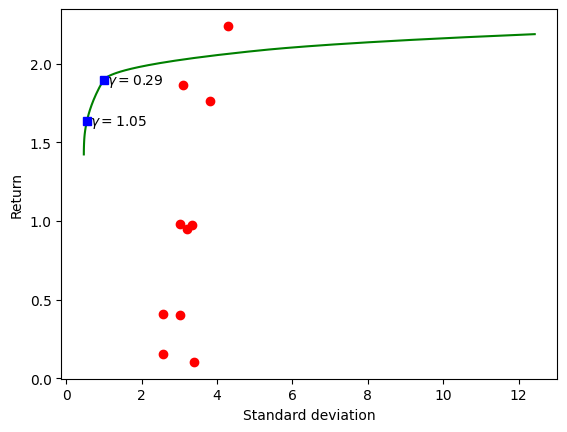

In [4]:
markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, "g-")
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], "bs")
    ax.annotate(
        r"$\gamma = %.2f$" % gammaList[marker],
        xy=(risk_data[marker] + 0.08, ret_data[marker] - 0.03),
    )
for i in range(n):
    plt.plot(np.sqrt(Sigma[i, i]), mu[i], "ro")
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.show()

## Worst-case Risk Analysis

$$
\begin{align}
\max_{\Sigma} \quad & w^T \Sigma w \\
\text{s.t.} \quad & \Sigma \in \mathcal{S},\ \Sigma \succeq 0 \\
& w = (-0.01,\ 0.13,\ 0.18,\ 0.88,\ -0.18) \\
& \text{optimized for } \Sigma_{\text{nom}},\ \text{return } 0.1,\ \text{leverage limit } 2 \\
& \mathcal{S} = \left\{ \Sigma_{\text{nom}} + \Delta : |\Delta_{ii}| = 0,\ |\Delta_{ij}| \leq 0.2 \right\}
\end{align}
$$

$$
\Sigma_{\text{nom}} =
\begin{bmatrix}
0.58 & 0.2 & 0.2 & 0.57 & -0.02 \\
0.2 & 0.43 & 0.36 & 0.24 & 0 \\
0.57 & 0.24 & 0.57 & -0.01 & 0.47 \\
-0.02 & 0 & -0.01 & 0.05 & 0.08 \\
0.43 & 0.38 & 0.47 & 0.08 & 0.92
\end{bmatrix}
$$

$$
\text{nominal risk} = 0.168 \\
\text{worst-case risk} = 0.422
$$

$$
\text{worst-case } \Delta =
\begin{bmatrix}
0 & 0.04 & -0.2 & 0 & 0.2 \\
0.04 & 0 & 0.2 & 0.09 & -0.2 \\
-0.2 & 0.2 & 0 & 0.12 & -0.2 \\
0 & 0.09 & 0.12 & 0 & -0.18 \\
0.2 & -0.2 & -0.2 & -0.18 & 0
\end{bmatrix}
$$

In [45]:
import numpy as np
import cvxpy as cp
from pyoptsparse import Optimization, SLSQP

n = 5
w = np.array([-0.01, 0.13, 0.18, 0.88, -0.18])
w = np.reshape(w, (5,1))
Sigma_nom = np.array([
    [0.58, 0.2, 0.57, -0.02, 0.43],
    [0.2, 0.36, 0.24, 0., 0.38],
    [0.57, 0.24, 0.57, -0.01, 0.47],
    [-0.02, 0, -0.01, 0.05, 0.08],
    [0.43, 0.38, 0.47, 0.08, 0.92]
]) # 5 * 5


def objfunc(xdict):
    x = xdict["xdict"]
    x = np.reshape(x, (5, 5))
    funcs = {}
    funcs["obj"] = - (w.T.dot(x + Sigma_nom).dot(w))
    con = [0] * 2
    con[0] = np.sum(abs(x)) - 2
    con[1] = abs(x[0][0]) + abs(x[1][1]) + abs(x[2][2]) + abs(x[3][3]) + abs(x[4][4])
    funcs["con"] = con

    fail = False
    return funcs, fail

optProb = Optimization("Worst-case Risk", objfunc)
optProb.addVarGroup("xdict", 25, "c", lower=-0.2, upper=0.2, value=0)
optProb.addConGroup("con", 2, lower=[None, 0.0], upper=0.0)
optProb.addObj("obj")

optOption = {"IPRINT": -1}
opt = SLSQP(options=optOption)
sol = opt(optProb, sens="FD")
delta = np.reshape(list(sol.xStar.values()), (5,5))

np.set_printoptions(threshold=np.inf, linewidth=200)
print(sol)
print(np.round(delta, 4))
print(np.sqrt(w.T @ Sigma_nom @ w))
print(np.sqrt(w.T.dot(Sigma_nom + delta).dot(w)))



Optimization Problem -- Worst-case Risk
    Objective Function: objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    1.9977
       User Objective Time :       0.1451
       User Sensitivity Time :     0.6332
       Interface Time :            0.8323
       Opt Solver Time:            0.3871
    Calls to Objective Function :    5069
    Calls to Sens Function :          501


   Objectives
      Index  Name            Value
          0  obj    -2.217508E-01

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name       Type      Lower Bound            Value      Upper Bound     Status
          0  xdict_0       c    -2.000000E-01    -4.751862E-07     2.000000E-01           
          1  xdict_1       c    -2.000000E-01    -4.130360E-07     2.000000E-01           
          2  xdict_2       c    -2.000000E-01    -6.626691E-07     2.000000E-01           
          3  xdict_3       c

## Ad Revenue
maximize $\sum_i S_i$  
subject to $D \geq 0$, $D \mathbf{1} \leq T$, $D \mathbf{1} \geq c$  
variable: $D \in \mathbb{R}^{m \times n}$  
data: $T$, $c$, $R$, $B$, $P$


In [ ]:
import numpy as np
from pyoptsparse import SLSQP, Optimization
import scipy.sparse as sp
import matplotlib.pyplot as plt

np.random.seed(1)
m = 5 # num ad
n = 24 # t hr
SCALE = 10000
B = [25000, 12000, 12000, 11000, 17000]

P_ad = np.random.uniform(size=(m, 1))
P_time = np.random.uniform(size=(1, n))
P = P_ad.dot(P_time)

print(P)

T = np.sin(np.linspace(-2*np.pi/2, 2*np.pi-2*np.pi/2, n)) * SCALE # traffic
T += -np.min(T) + SCALE
c = [61000, 80000, 61000, 23000, 64000]
R = [0.15, 1.18, 0.57, 2.08, 2.43]

def objfunction(xdict):
    d = xdict["xvars"]
    d = np.reshape(d, (m,n))
    funcs={}
    
    sum = 0
    for i in range(m): # ad
        sum += min(R[i] * P[i, :].dot(d[i, :].T), B[i])
    funcs["obj"] = - sum
    conval = [0] * (n+m)
    for t in range(n):
        sumdi = 0
        for i in range(m):
            sumdi += d[i][t]
        conval[t] = sumdi-T[t]
    for i in range(m):
        sumdt = 0
        for t in range(n):
            sumdt += d[i][t]
        conval[n-1+i] = c[i] - sumdt
        
    # conval = [0] * 2
    # temp = d.T@np.ones(m) - T
    # conval[0] = temp[0]
    # temp1 = c - d@np.ones(n)
    # print(d@np.ones(n))
    # conval[1] = temp1[0]

    funcs["con"] = conval
    fail = False
    return funcs, fail
optprob = Optimization("ad", objfunction)
optprob.addVarGroup("xvars", m * n, "c", lower=0.0, upper=None, value=1000)
optprob.addConGroup("con", m+n, lower=None, upper=0.0)
optprob.addObj("obj")

optoption = {"IPRINT": -1}
opt = SLSQP(options=optoption)
sol = opt(optprob, sens = "FD")

print(sol)
d_opt = sol.getDVs()["xvars"]
d_opt = np.reshape(d_opt, (m,n))
print(np.round(np.sum(d_opt, axis=1),1))
sumclist = []
for i in range(m): # ad
    sumc = min(R[i] * P[i, :].dot(d_opt[i, :].T), B[i])
    sumclist.append(np.round(sumc, 1))
print(sumclist)

[[0.  0.1 0.1 0.2 0.2 0.2 0.3 0.1 0.4 0.  0.3 0.2 0.2 0.1 0.1 0.3 0.4 0.1
  0.3 0.4 0.4 0.  0.  0.1]
 [0.1 0.1 0.2 0.3 0.4 0.3 0.5 0.1 0.6 0.  0.5 0.3 0.4 0.1 0.1 0.6 0.7 0.2
  0.5 0.6 0.6 0.1 0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.1 0.1 0.2 0.1 0.2 0.1 0.3 0.  0.2 0.1 0.2 0.  0.1 0.2 0.3 0.1
  0.2 0.3 0.3 0.  0.  0.1]
 [0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.1 0.  0.1 0.1 0.1 0.  0.  0.1 0.1 0.
  0.1 0.1 0.1 0.  0.  0. ]]


Optimization Problem -- ad
    Objective Function: objfunction

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    2.0117
       User Objective Time :       0.0323
       User Sensitivity Time :     1.3729
       Interface Time :            0.1965
       Opt Solver Time:            0.4099
    Calls to Objective Function :     256
    Calls to Sens Function :           77


   Objectives
      Index  Name       

In [ ]:
plt.plot(T)
plt.xlabel("Hour")
plt.ylabel("Traffic")
plt.show()